In [1]:
# from mnist import MNIST

# mnist = MNIST('/home/bnapp/datasets/mnist/')
# images, labels = mnist.load_training()



In [2]:
import numpy as np
import cv2
import misc

import importlib
importlib.reload(misc)

In [3]:
""" Convolutional Neural Network.
Build and train a convolutional neural network with TensorFlow.
This example is using the MNIST database of handwritten digits
(http://yann.lecun.com/exdb/mnist/)
This example is using TensorFlow layers API, see 'convolutional_network_raw' 
example for a raw implementation with variables.
Author: Aymeric Damien - modified by Alexander Rivkind
Project: https://github.com/aymericdamien/TensorFlow-Examples/
"""
from __future__ import division, print_function, absolute_import

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

import tensorflow as tf

# Training Parameters
learning_rate = 0.001
num_steps = 3000
batch_size = 128

# Network Parameters
size=(28,28)
padding_size=(56,56)
num_input = padding_size[0]*padding_size[1] # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
def scale_mnist_mat(image_mat,size=(28,28),orig_size=(28,28),padding=(28,28),offset=(0,0)):
    o=np.zeros([np.shape(image_mat)[0]]+list(padding))
    for ii,image in enumerate(image_mat):
        img_sc=cv2.resize(0.0+np.reshape(image,list(orig_size)), dsize=size)
        #todo: x/y row/column convention
        o[ii,:]=misc.build_mnist_padded([img_sc],y_size=size[1],x_size=size[0],xx=padding[0],yy=padding[1],offset=offset)
    return o    

In [5]:
scaled_train = scale_mnist_mat(mnist.train.images,padding=padding_size)

In [6]:
scaled_test = scale_mnist_mat(mnist.test.images,padding=padding_size)
scaled_test_2x = scale_mnist_mat(mnist.test.images,padding=padding_size,size=(56,56))

In [7]:
scaled_test_1p5x = scale_mnist_mat(mnist.test.images,padding=padding_size,size=(42,42))

In [8]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, padding_size[0], padding_size[1], 1])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)


        # Convolution Layer with 64 filters and a kernel size of 3
        conv3 = tf.layers.conv2d(conv2, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv3 = tf.layers.max_pooling2d(conv3, 2, 2)


        # Convolution Layer with 64 filters and a kernel size of 3
        conv4 = tf.layers.conv2d(conv3, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv4 = tf.layers.max_pooling2d(conv4, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv4)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024, activation=tf.nn.relu)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out


# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False,
                            is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True,
                           is_training=False)

    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)

    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes)

        # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op,
                                  global_step=tf.train.get_global_step())

    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=pred_classes,
        loss=loss_op,
        train_op=train_op,
        eval_metric_ops={'accuracy': acc_op})

    return estim_specs

# Build the Estimator
model = tf.estimator.Estimator(model_fn)

# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': scaled_train.reshape([-1,padding_size[0], padding_size[1]])}, y=mnist.train.labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': scaled_test.reshape([-1,padding_size[0], padding_size[1]])}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
e = model.evaluate(input_fn)

print("Testing Accuracy:", e['accuracy'])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': 'worker', '_eval_distribute': None, '_device_fn': None, '_num_worker_replicas': 1, '_train_distribute': None, '_save_checkpoints_steps': None, '_evaluation_master': '', '_service': None, '_num_ps_replicas': 0, '_task_id': 0, '_tf_random_seed': None, '_model_dir': '/tmp/tmp79fu2kc1', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4e6443ce48>, '_save_summary_steps': 100, '_is_chief': True, '_protocol': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_global_id_in_cluster': 0, '_log_step_count_steps': 100, '_experimental_distribute': None, '_keep_checkpoint_max': 5, '_master': '', '_keep_checkpoint_every_n_hours': 10000}
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, u

In [9]:
offsets=list(range(14))
errors=[]
for this_offset in offsets:
    scaled_test = scale_mnist_mat(mnist.test.images,padding=padding_size,size=(28,28),offset=(this_offset,this_offset))
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'images': scaled_test.reshape([-1,padding_size[0], padding_size[1]])}, y=mnist.test.labels,
        batch_size=batch_size, shuffle=False)
    # Use the Estimator 'evaluate' method
    e = model.evaluate(input_fn)

    print("Testing Accuracy:", e['accuracy'])
    errors.append(e)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-12-30-14:14:01
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp79fu2kc1/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-12-30-14:14:08
INFO:tensorflow:Saving dict for global step 3000: accuracy = 0.9898, global_step = 3000, loss = 0.034549914
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: /tmp/tmp79fu2kc1/model.ckpt-3000
Testing Accuracy: 0.9898
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-12-30-14:14:09
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp79fu2kc1/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-12-30-

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp79fu2kc1/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-12-30-14:15:51
INFO:tensorflow:Saving dict for global step 3000: accuracy = 0.1745, global_step = 3000, loss = 2.8400543
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: /tmp/tmp79fu2kc1/model.ckpt-3000
Testing Accuracy: 0.1745


In [10]:
print([uu for uu in zip(offsets,errors)])

[(0, {'accuracy': 0.9898, 'global_step': 3000, 'loss': 0.034549914}), (1, {'accuracy': 0.9827, 'global_step': 3000, 'loss': 0.054789428}), (2, {'accuracy': 0.9429, 'global_step': 3000, 'loss': 0.19857286}), (3, {'accuracy': 0.7977, 'global_step': 3000, 'loss': 0.6768653}), (4, {'accuracy': 0.5245, 'global_step': 3000, 'loss': 1.6497146}), (5, {'accuracy': 0.3636, 'global_step': 3000, 'loss': 2.6114762}), (6, {'accuracy': 0.2801, 'global_step': 3000, 'loss': 3.2643776}), (7, {'accuracy': 0.2569, 'global_step': 3000, 'loss': 3.3861182}), (8, {'accuracy': 0.2176, 'global_step': 3000, 'loss': 3.412941}), (9, {'accuracy': 0.2258, 'global_step': 3000, 'loss': 3.375088}), (10, {'accuracy': 0.2452, 'global_step': 3000, 'loss': 3.2404869}), (11, {'accuracy': 0.2452, 'global_step': 3000, 'loss': 3.0792704}), (12, {'accuracy': 0.2142, 'global_step': 3000, 'loss': 2.9600494}), (13, {'accuracy': 0.1745, 'global_step': 3000, 'loss': 2.8400543})]


In [11]:
e2=[uu['accuracy'] for uu in errors]

In [12]:
print(list(zip(offsets,e2)))

[(0, 0.9898), (1, 0.9827), (2, 0.9429), (3, 0.7977), (4, 0.5245), (5, 0.3636), (6, 0.2801), (7, 0.2569), (8, 0.2176), (9, 0.2258), (10, 0.2452), (11, 0.2452), (12, 0.2142), (13, 0.1745)]


In [20]:
#values for syclop. Copied from another notebook (action_logit_games_padding1_cleaned_evaluator.ipynb)
syc_offsets=[0,5,10]
syc_e=[0.8311582381729201,0.8207585644371941,0.8187194127243067]

mlp_e=[0.9762,
 0.8982,
 0.5125,
 0.2167,
 0.067,
 0.0367,
 0.0469,
 0.0544,
 0.0635,
 0.0703,
 0.0832,
 0.0984,
 0.1062,
 0.1154]

In [14]:
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


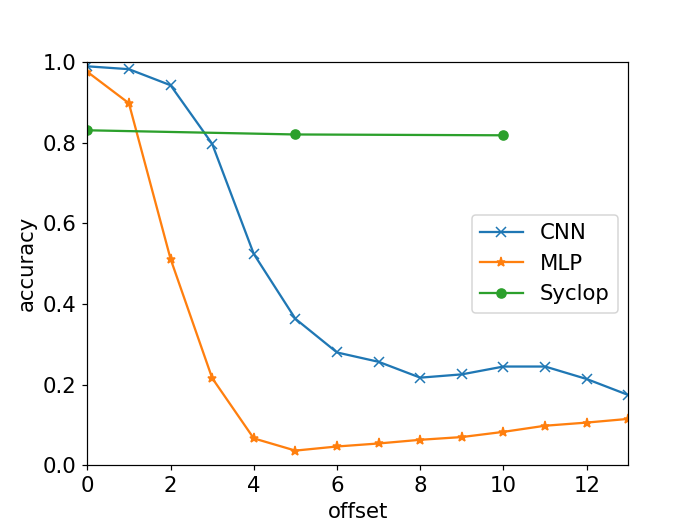

(0, 13)

In [31]:
plt.figure()
matplotlib.rcParams.update({'font.size': 14})
plt.plot(offsets,e2,'x-')
plt.plot(offsets,mlp_e,'*-')
plt.plot(syc_offsets,syc_e,'o-')
plt.xlabel('offset')
plt.ylabel('accuracy')
plt.legend(['CNN','MLP','Syclop'])
plt.ylim([0,1.0])
plt.xlim([0,13])

In [32]:
demo1 = scale_mnist_mat(mnist.test.images,padding=padding_size,size=(28,28),offset=(0,0))
demo2 = scale_mnist_mat(mnist.test.images,padding=padding_size,size=(28,28),offset=(10,10))


<IPython.core.display.Javascript object>


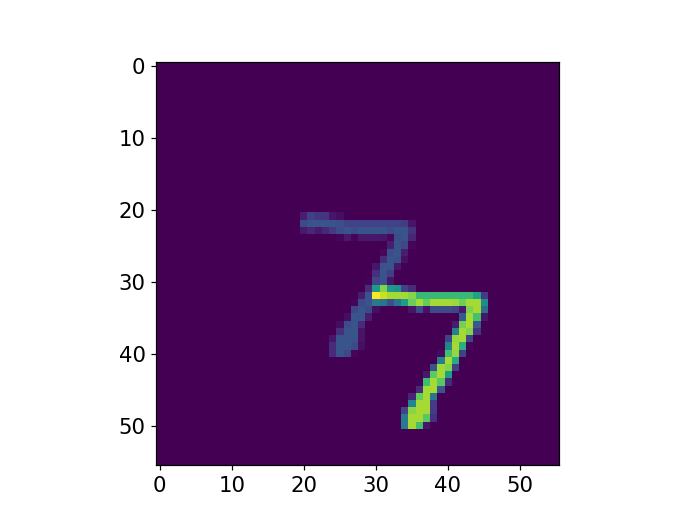

In [33]:
plt.figure()
plt.imshow(0.3*demo1[0]+demo2[0])

<IPython.core.display.Javascript object>


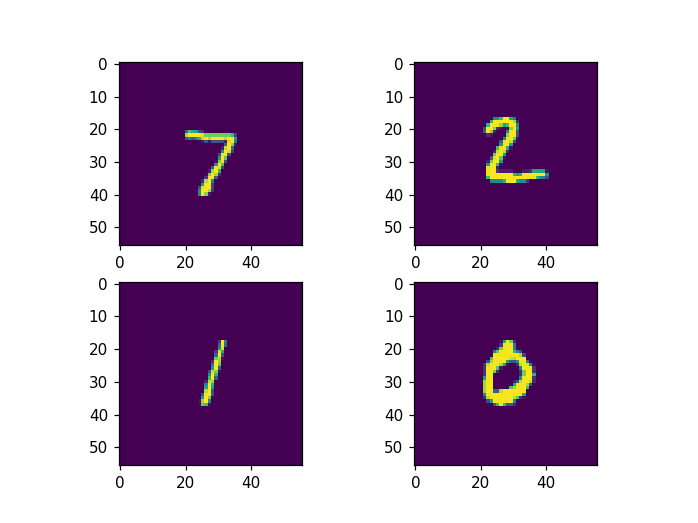

In [18]:
plt.figure()

for ii in range(4):
    plt.subplot(2,2,ii+1)
    plt.imshow(demo1[ii])

In [27]:
import matplotlib